In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
%cd ../

/home/wilson/DiffTraj


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from types import SimpleNamespace
from utils.Traj_UNet import *
from utils.config import args
from utils.utils import *
from torch.utils.data import DataLoader

/home/wilson/micromamba/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [4]:
temp = {}
for k, v in args.items():
    temp[k] = SimpleNamespace(**v)

config = SimpleNamespace(**temp)

unet = Guide_UNet(config).cuda()
# load the model
unet.load_state_dict(torch.load('models/Rome_steps=500_len=200_0.05_bs=1024/models/01-23-02-46-39/unet_200.pt'))

<All keys matched successfully>

In [5]:
n_steps = config.diffusion.num_diffusion_timesteps
beta = torch.linspace(config.diffusion.beta_start, config.diffusion.beta_end, n_steps).cuda()
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
lr = 2e-4  # Explore this - might want it lower when training on the full dataset

eta = 0.0
timesteps = 100
skip = n_steps // timesteps
seq = range(0, n_steps, skip)

# load head information for guide trajectory generation
batchsize = 500
head = np.load("data/rome_test_attributes.npy", allow_pickle=True)
head = torch.from_numpy(head).float()
dataloader = DataLoader(head, batch_size=batchsize, shuffle=True, num_workers=4)

In [ ]:
# # the mean and std of head information, using for rescaling
# # departure_time, trip_distance,  trip_time, trip_length, avg_dis, avg_speed
# hmean = [0, 10283.41600429, 961.66920921, 292.30299616, 36.02766493, 10.98568072]
# hstd = [1, 8782.599246414231, 379.41939897358264, 107.24874828393955, 28.749924691281066, 8.774629812281198]
# mean = np.array([104.07596303, 30.68085491])  # lon, lat
# std = np.array([2.15106194e-02, 1.89193207e-02])

# # the original mean and std of trajectory length, using for rescaling the trajectory length
# len_mean = 292.30299616  # Chengdu
# len_std = 107.2487482839  # Chengdu

In [6]:
import json

with open("data/rome_stats.json", "r") as f:
    stats = json.load(f)

hmean = [0, stats["trip_distance"]["mean"], stats["trip_time"]["mean"], stats["trip_length"]["mean"], stats["avg_dis"]["mean"], stats["avg_speed"]["mean"]]
hstd = [1, stats["trip_distance"]["std"], stats["trip_time"]["std"], stats["trip_length"]["std"], stats["avg_dis"]["std"], stats["avg_speed"]["std"]]
mean = np.array([stats["lon"]["mean"], stats["lat"]["mean"]])
std = np.array([stats["lon"]["std"], stats["lat"]["std"]])
len_mean = stats["traj_len"]["mean"]
len_std = stats["traj_len"]["std"]

In [7]:
Gen_traj = []
Gen_head = []
for _ in tqdm(range(1)):
    head = next(iter(dataloader))
    lengths = head[:, 3]
    lengths = lengths * len_std + len_mean
    lengths = lengths.int()
    tes = head[:, :6].numpy()
    Gen_head.extend((tes * hstd + hmean))
    head = head.cuda()
    # Start with random noise
    x = torch.randn(batchsize, 2, config.data.traj_length).cuda()
    ims = []
    n = x.size(0)
    seq_next = [-1] + list(seq[:-1])
    for i, j in zip(reversed(seq), reversed(seq_next)):
        t = (torch.ones(n) * i).to(x.device)
        next_t = (torch.ones(n) * j).to(x.device)
        with torch.no_grad():
            pred_noise = unet(x, t, head)
            # print(pred_noise.shape)
            x = p_xt(x, pred_noise, t, next_t, beta, eta)
            if i % 10 == 0:
                ims.append(x.cpu().squeeze(0))
    trajs = ims[-1].cpu().numpy()
    trajs = trajs[:, :2, :]
    # resample the trajectory length
    for j in range(batchsize):
        new_traj = resample_trajectory(trajs[j].T, lengths[j])
        new_traj = new_traj * std + mean
        Gen_traj.append(new_traj)

100%|██████████| 1/1 [00:13<00:00, 13.54s/it]


In [9]:
import folium

path = Gen_traj[1].tolist()
path = [[p[1], p[0]] for p in path]

m = folium.Map(location=path[0], zoom_start=15, tiles="cartodbpositron")

folium.PolyLine(path, color="#3388ff", weight=5, opacity=0.8, tooltip="Trajectory Trace").add_to(m)
folium.CircleMarker(path[0], color="green", radius=5, fill=True, popup="Start").add_to(m)
folium.CircleMarker(path[-1], color="red", radius=5, fill=True, popup="End").add_to(m)
# m.save("Rome_traj.html")
m

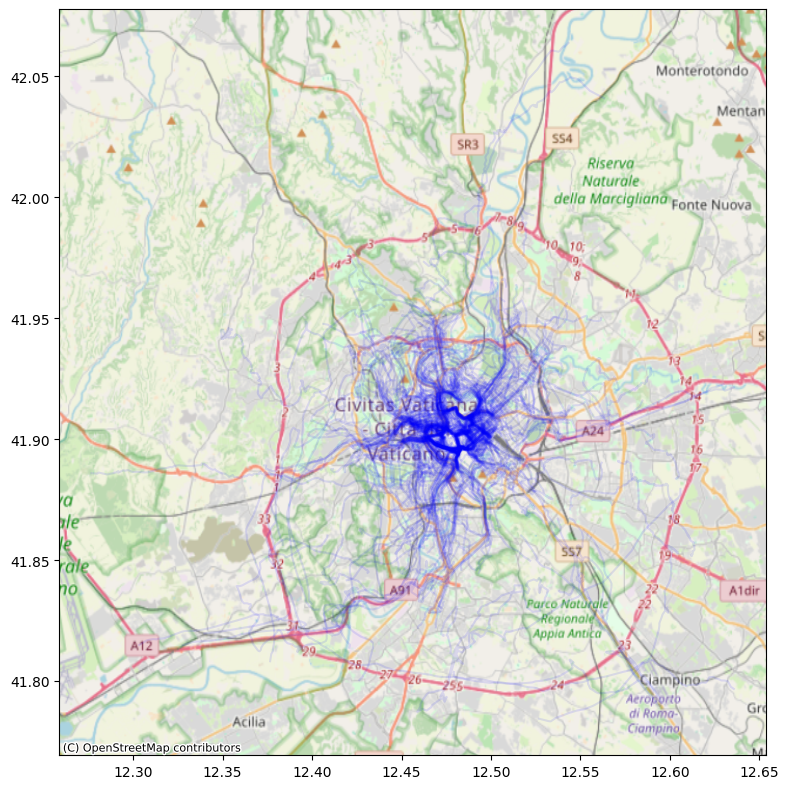

In [8]:
import contextily as ctx

plt.figure(figsize=(8, 8))
for i in range(len(Gen_traj)):
    traj = Gen_traj[i]
    plt.plot(traj[:, 0], traj[:, 1], color="blue", alpha=0.1)
ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
plt.tight_layout()
plt.show()